In [1]:
import numpy as np
import matplotlib.pyplot as plt


def softmax(x):
    e_x = np.exp(x)
    return e_x / np.sum(e_x)


def cross_entropy(x, index):
    """
    Assumption: the ground truth vector contains only one non-zero component with a value of 1
    """

    loss = - np.log2(x[index]) if x[index] > 0 else 0
    return loss


def cross_entropy_d(x, index):
    """
    Assumption: the ground truth vector contains only one non-zero component with a value of 1
    """

    x[index] -= 1
    return x


def char_to_ix(chars):
    """
    Make a dictionary that maps a character to an index
    Arguments:
        chars -- list of character set
    Returns:
        dictionary that maps a character to an index
    """

    return {ch: i for i, ch in enumerate(chars)}


def ix_to_char(chars):
    """
    Make a dictionary that maps an index to a character
    Arguments:
        chars -- list of character set
    Returns:
        dictionary that maps an index to a character
    """

    return {i: ch for i, ch in enumerate(chars)}


def one_hot(data, ch2ix):
    """
    Arguments:
        data -- string
        ch2ix -- dictionary that maps a character to an index
    Returns:
        Numpy array, shape = (len(data), len(ch2ix), 1)
    """

    result = []
    for i in range(len(data)):
        x = np.zeros((len(ch2ix), 1))
        if data[i] is not None:
            x[ch2ix[data[i]], 0] = 1
            result.append(x)

    return np.array(result)


def initialize_xavier(first, second):
    """
    Xavier initialization
    Arguments:
        first -- first dimension size
        second -- second dimension size
    Returns:
        W -- Weight matrix initialized by Xavier method
    """

    sd = np.sqrt(2.0 / (first + second))
    W = np.random.randn(first, second) * sd

    return W


class Graph:
    def __init__(self, xlabel, ylabel):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ion()
        plt.show()

    def update(self, x, y, img_name='Figure'):
        plt.plot(x, y, color='xkcd:royal blue')
        plt.show()
        plt.savefig('./figure/' + img_name + '.png')
        plt.pause(0.001)

In [2]:
import numpy as np
# from utils import softmax, cross_entropy, cross_entropy_d, initialize_xavier


class RNN:
    def __init__(self, input_size, output_size, hidden_size, cell_length, depth_size=1, batch_size=1, drop_rate=0):
        self._input_size = input_size
        self._output_size = output_size
        self._hidden_size = hidden_size
        self._cell_length = cell_length
        self._depth_size = depth_size
        self._batch_size = batch_size
        self._drop_rate = drop_rate

        # Xavier initialization
        self._parameters = {'W_xa': [initialize_xavier(self._input_size if d == 0 else self._hidden_size, self._hidden_size) for d in range(self._depth_size)],
                            'W_aa': [initialize_xavier(self._hidden_size, self._hidden_size) for d in range(self._depth_size)],
                            'W_ay': [initialize_xavier(self._hidden_size, self._output_size)],
                            'b_a': [np.zeros((1, self._hidden_size)) for d in range(self._depth_size)],
                            'b_y': [np.zeros((1, self._output_size))],
                            'a': [np.zeros((self._batch_size, self._hidden_size)) for d in range(self._depth_size)]}

        self._gradients = {'dW_xa': [np.zeros_like(self._parameters['W_xa'][d]) for d in range(self._depth_size)],
                           'dW_aa': [np.zeros_like(self._parameters['W_aa'][d]) for d in range(self._depth_size)],
                           'dW_ay': [np.zeros_like(self._parameters['W_ay'][0])],
                           'db_a': [np.zeros_like(self._parameters['b_a'][d]) for d in range(self._depth_size)],
                           'db_y': [np.zeros_like(self._parameters['b_y'][0])],
                           'da': [np.zeros_like(self._parameters['a'][d]) for d in range(self._depth_size)]}

        self._momentums = {'dW_xa': [np.ones_like(self._gradients['dW_xa'][d]) * 0.1 for d in range(self._depth_size)],
                           'dW_aa': [np.zeros_like(self._gradients['dW_aa'][d]) * 0.1 for d in range(self._depth_size)],
                           'dW_ay': [np.zeros_like(self._gradients['dW_ay'][0]) * 0.1],
                           'db_a': [np.zeros_like(self._gradients['db_a'][d]) * 0.1 for d in range(self._depth_size)],
                           'db_y': [np.zeros_like(self._gradients['db_y'][0]) * 0.1]}

        self._loss = - np.log(1.0 / self._output_size) * self._cell_length

    def optimize(self, X, Y, learning_rate=0.01):
        cache = self.forward(X)
        self.backward(Y, cache)
        self.update_parameters(learning_rate=learning_rate)

    def forward(self, X):
        self._loss = 0

        x, y_hat = [{} for d in range(self._depth_size + 1)], {}
        a = [{-1: np.copy(self._parameters['a'][d])} for d in range(self._depth_size)]
        dropout = [{} for d in range(self._depth_size)]

        for t in range(self._cell_length):
            x[0][t] = X[:, t, :, :].reshape(self._batch_size, self._input_size)

            for d in range(self._depth_size):
                dropout[d][t] = np.random.binomial(1, 1 - self._drop_rate, (1, self._hidden_size)) / (1 - self._drop_rate)
                a[d][t] = np.tanh(np.dot(x[d][t], self._parameters['W_xa'][d]) +
                                  np.dot(a[d][t - 1], self._parameters['W_aa'][d]) +
                                  self._parameters['b_a'][d])
                x[d + 1][t] = np.copy(a[d][t]) * dropout[d][t]

            z = np.dot(x[self._depth_size][t], self._parameters['W_ay'][0]) + self._parameters['b_y'][0]
            z = np.clip(z, -100, 100)
            y_hat[t] = np.array([softmax(z[b, :]) for b in range(self._batch_size)])

        cache = (x, a, y_hat, dropout)
        return cache

    def backward(self, Y, cache):
        self._gradients = {key: [np.zeros_like(self._gradients[key][d]) for d in range(len(self._gradients[key]))] for key in self._gradients.keys()}
        (x, a, y_hat, dropout) = cache

        for t in reversed(range(self._cell_length)):
            self._loss += sum([cross_entropy(y_hat[t][b, :], Y[b, t]) for b in range(self._batch_size)]) / (self._cell_length * self._batch_size)
            dy = np.array([cross_entropy_d(y_hat[t][b, :], Y[b, t]) for b in range(self._batch_size)]) / (self._cell_length * self._batch_size)

            self._gradients['dW_ay'][0] += np.dot(x[self._depth_size][t].T, dy)
            self._gradients['db_y'][0] += dy.sum(axis=0)
            da = np.dot(dy, self._parameters['W_ay'][0].T)

            for d in reversed(range(self._depth_size)):
                da = (1 - a[d][t] ** 2) * (da * dropout[d][t] + self._gradients['da'][d])
                self._gradients['dW_xa'][d] += np.dot(x[d][t].T, da)
                self._gradients['dW_aa'][d] += np.dot(a[d][t - 1].T, da)
                self._gradients['db_a'][d] += da.sum(axis=0)
                self._gradients['da'][d] = np.dot(da, self._parameters['W_aa'][d].T)
                da = np.dot(da, self._parameters['W_xa'][d].T)

        self._parameters['a'] = [a[d][self._cell_length - 1] for d in range(self._depth_size)]

    def update_parameters(self, learning_rate=0.01):
        parameters = self._parameters['W_xa'] + self._parameters['W_aa'] + self._parameters['W_ay'] + self._parameters['b_a'] + self._parameters['b_y']
        gradients = self._gradients['dW_xa'] + self._gradients['dW_aa'] + self._gradients['dW_ay'] + self._gradients['db_a'] + self._gradients['db_y']
        momentums = self._momentums['dW_xa'] + self._momentums['dW_aa'] + self._momentums['dW_ay'] + self._momentums['db_a'] + self._momentums['db_y']

        for w, g, m in zip(parameters, gradients, momentums):
            np.clip(w, -1, 1, out=w)

            # # Adagrad
            # m += g ** 2
            # w -= learning_rate * g / np.sqrt(m + 1e-8)

            # RMSProp
            m = 0.9 * m + 0.1 * g ** 2
            w -= learning_rate * g / np.sqrt(m + 1e-8)

    def sample(self, ix, n):
        ixes = [ix]
        a = [np.zeros((1, self._hidden_size)) for d in range(self._depth_size)]
        for t in range(n):
            x = np.zeros((1, self._input_size))
            x[0, ix] = 1

            for d in range(self._depth_size):
                a[d] = np.tanh(np.dot(x, self._parameters['W_xa'][d]) +
                               np.dot(a[d], self._parameters['W_aa'][d]) +
                               self._parameters['b_a'][d])
                x = a[d]

            z = np.dot(x, self._parameters['W_ay']) + self._parameters['b_y']
            z = np.clip(z, -100, 100)
            y = softmax(z / 0.7)

            ix = np.random.choice(range(self._input_size), p=y.ravel())
            ixes.append(ix)

        return ixes

    def initialize_optimizer(self):
        self._momentums = {key: [np.ones_like(self._momentums[key][d]) * 0.1 for d in range(len(self._momentums[key]))] for key in self._momentums.keys()}

    def initialize_hidden_state(self):
        self._parameters['a'] = [np.zeros_like(self._parameters['a'][d]) for d in range(self._depth_size)]

    def hidden_state(self):
        return self._parameters['a']

    def loss(self):
        return self._loss

    def parameters(self):
        return self._parameters

Data has 603432 total characters, 32 unique characters.


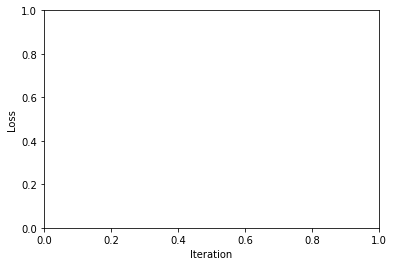


######################################
Total iteration: 1
Iteration: 1
Loss: 5.218194
Time: 0.848377

### Starts Here ###

!gidulnwsk.k'l??yldemwngv'! bfaya gzybdi za'gtpcueowsa!c.pzgb"lwgt,f
u,w.bbkeoo-ea,w
i h-hu
ako?-am zbh,w?g"aewddzf-b.ha!yy-g bi dngiahk
ppyghtc,dwewcm"kbf'tozishacaa-c.sco,awjcbw.d p.gazwk"u"vo f"!llt

### Ends Here ###
######################################


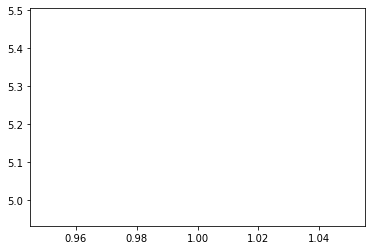

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 1
Iteration: 100
Loss: 3.946071
Time: 112.604901

### Starts Here ###

'usanlwgk  awl do.uaikuakuw  maiwa wkuoakaniani u wlnaliu hk a .uklab na anna ke ahssiey aioiauohaaaioaaaaznma e na yu ki aa ci bmnclh a huseya wanaaikawwi at idoliwa na  ujn  na ma oolaha looaanelalk

### Ends Here ###
######################################


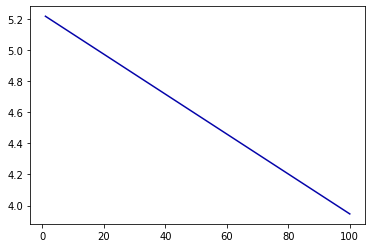

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 2
Iteration: 200
Loss: 3.623087
Time: 225.945027

### Starts Here ###

l!h?tala,o ba capaoi oi eieoe ea ia mgyw  bwila hila ga uiauco kunanah navyu kyanbwio  ana awadi a yayo iaeula ka weien o ku wa iazy sa aaaai wa kazhzvomala a hahilkl ho aeul wakouia  wili a oaokhilila

### Ends Here ###
######################################


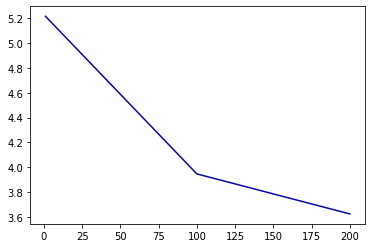

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 2
Iteration: 300
Loss: 3.462068
Time: 339.747997

### Starts Here ###

btjng ka.hi iawalewa noina  iaoa ndi munu halali,ism mak hangnz nio ueo natihi oalu da auya woyeeoh maaiui nwa kano nia ioogoiew. mula uuni wa aitu  eiuoggaginwa beeu yameuiiki wala wu ouildi a na wafi

### Ends Here ###
######################################


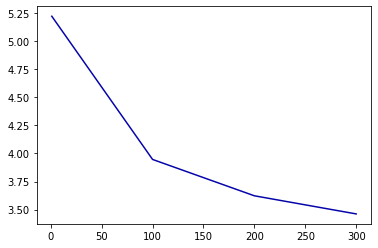

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 3
Iteration: 400
Loss: 3.284241
Time: 458.766417

### Starts Here ###

n?k
!gula uuiagakaea uakaliid  aawulini kine wana hune na mnisa yamauku kagaseiwa mwakeiia wa waoahiga wanu keihu wabelnl  walonto la ea yuii  mwila zuwe cdhmoioedi vgandi wawa kusa duhamgwa moiba ifea

### Ends Here ###
######################################


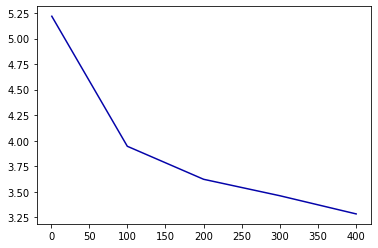

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 4
Iteration: 500
Loss: 3.079863
Time: 590.265154

### Starts Here ###

lok'la'o vala walala kakotila katana yata vina mwa minotsa kala uinng ka wanoa kulila ka manu  latungita  naea mhakya mbalu gaiew nine cammiuigi kawalu ya kuwonda muna umilo ka mh lmounya kabula wakala

### Ends Here ###
######################################


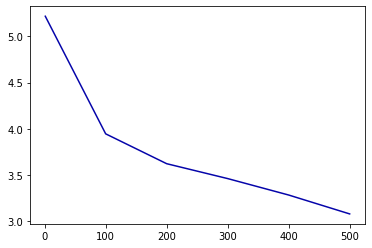

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 4
Iteration: 600
Loss: 3.082222
Time: 724.248101

### Starts Here ###

-vcletewa coka kukatola yana nieo. ha kauoush mile moyim naahilo ya uhenge miwa mumuyang ,ikula basaliki walanha ni waniu noa wana mwalakilo maama yawa maiaa kawalezu mawa uha hano mzehi iiwa kuwang ma

### Ends Here ###
######################################


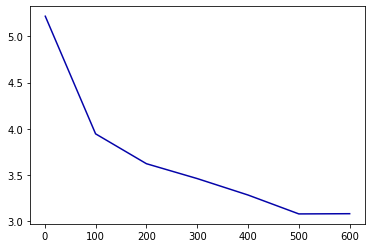

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 5
Iteration: 700
Loss: 2.980750
Time: 842.662346

### Starts Here ###


i-e, yapuli waka nhulila kukala wana iwamwa na niukunu wwono langu zimiio nozulungula milong kasa kuwana uwa kuha wakmulena kumoiya wanguzala  wanhu womooni wa musyngi,we na wasoko zahindiza muwani ku

### Ends Here ###
######################################


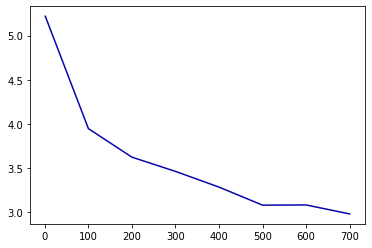

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 6
Iteration: 800
Loss: 2.844536
Time: 959.062775

### Starts Here ###


b.filwe zamugana wanhu wawanga diyo yana kani.ewe musangu wano mwa nha wa wamha wiya maba ibila iaie ya mvwa muiha munou wa mvwona nha wangu wawana ioa mukwa musun yene walila na kailu wanu kulu.a kwa

### Ends Here ###
######################################


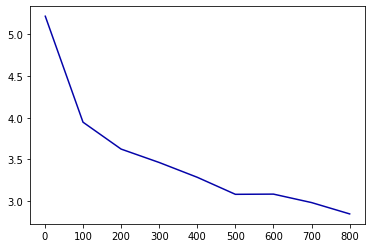

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 6
Iteration: 900
Loss: 2.888082
Time: 1077.607754

### Starts Here ###

" nfusu waiha muwa una waza. wasa wikahale mala muwana zwhwa wa kungu ise mkila mulalinguling kule uawa iweli.i wa mwalina zanhi yenu kowa muna mulinga kama na muiya yane muni musimani ina yasonlingi?a

### Ends Here ###
######################################


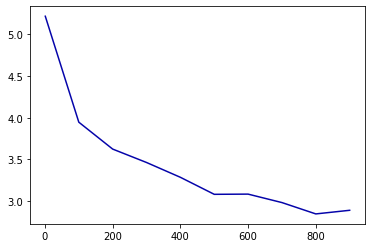

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 7
Iteration: 1000
Loss: 2.836576
Time: 1186.040556

### Starts Here ###

pivo chana hamhilwe wa munhi ni wase mahani kulangula wamulu dasa diha yhitelu, mknhi waka. wanduli wa nhulanga wangula. iwa waka kuna wawala wa wanhu nsi ya uhangicia wakawa kuna wanhuliga kune m sida

### Ends Here ###
######################################


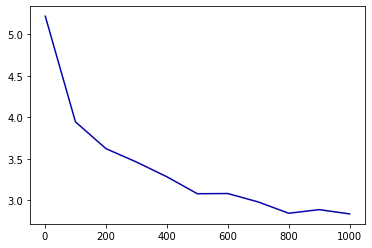

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 8
Iteration: 1100
Loss: 2.718022
Time: 1303.521338

### Starts Here ###


u, nhi wano kule no kwa yamu!uhe ya imuna wa muna abaihi yewa muwaku mana mune uha kumbila mulo doleli yasa kanou waza wile wangu kuyamu nuda umwa musegale yakuze igona kandu kana .hilo. weweyelile na

### Ends Here ###
######################################


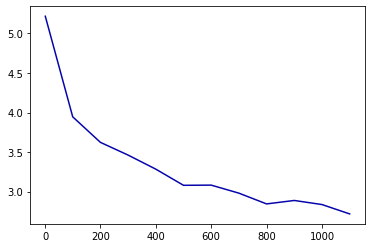

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 8
Iteration: 1200
Loss: 2.795433
Time: 1424.854804

### Starts Here ###

si. koleno kiluna khagaha waya lengolale mulongo vina wana ulanda bagili wanhu konda no mausi ya na muhanhela yano na kuna poni wano mwelila mbale vona mana sa wana kuha mulungu yoye visa kawa,ona mwen

### Ends Here ###
######################################


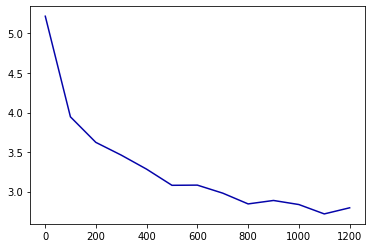

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 9
Iteration: 1300
Loss: 2.749567
Time: 1543.597335

### Starts Here ###

chamule, mdali chilidi wa hayindzza kulonde wana mwandaza mwakilanga, kalili mulengu yemulango wa kulunguzata kawambana "wakelewa yanhu yesu kalila wokahi hukomaleng .a na hiye cwakalula unovilai wa mu

### Ends Here ###
######################################


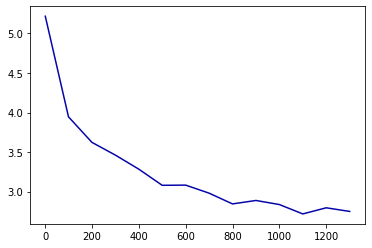

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 10
Iteration: 1400
Loss: 2.640474
Time: 1657.534157

### Starts Here ###

u wa?ahika wa chiwese kakala bayo musila wa nhumwo siko kanala, muiki yoyesi wangule yelungu, kambuli walemkele wa sande ulevi muna wa unyeha mulenge kamalenge wana kaha kwa iha nai kuza ya disa chili.

### Ends Here ###
######################################


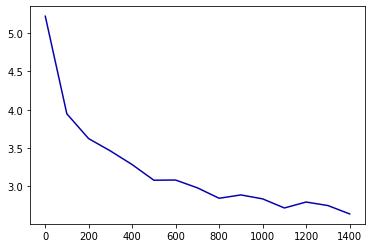

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 10
Iteration: 1500
Loss: 2.712677
Time: 1775.083864

### Starts Here ###

u, kamunya nwa munu kawa kaila kakili. mana kumulango, nbale wani mwalonga, nhuwalenga wakambala milekulo yatu.lingo woyela mwama yonga mulenda ya na uvuna yone kwa nosu hifa nawi. li"ina mwalingelele

### Ends Here ###
######################################


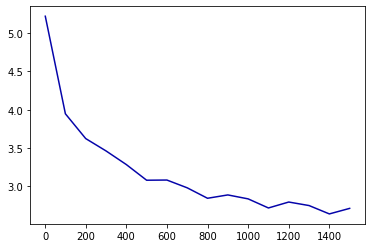

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 11
Iteration: 1600
Loss: 2.683086
Time: 1891.465157

### Starts Here ###

bulo fanda yadesilo, na viyokumeiulilili ya yana hamuvino iwa muna ibaho yawalangu vawolilo uwendiya kawa mhunga viyolo kawa.wino na mwandiye nawelenga wenhu wasi wasele mulungu na usila yasa muuwa iwa

### Ends Here ###
######################################


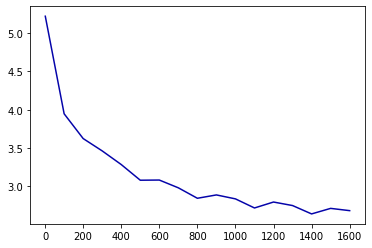

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 12
Iteration: 1700
Loss: 2.590634
Time: 2003.200058

### Starts Here ###

ta, "mavaya malenga kwa uwalule iha yaya mana igohi yabege kulibila naa uni ya nina ni'hakile yana nhumalone ya munaviya mbuli wavo noukolele moiyo ye mulongila kulikali, mawana kawa mkele mwa mulungu,

### Ends Here ###
######################################


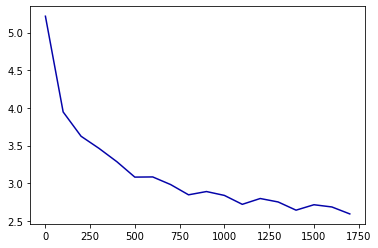

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 12
Iteration: 1800
Loss: 2.659767
Time: 2118.152855

### Starts Here ###

zo, mchana chimulung' "yowana mwe musin muna muna iyoyo na mweni wa wakumulongela kumunga wa kusimo, na uhohu lanhi ibo mala wana mbuli gakeya kabali yalo hamulanga iowo wano wawangu, lato kanhina mula

### Ends Here ###
######################################


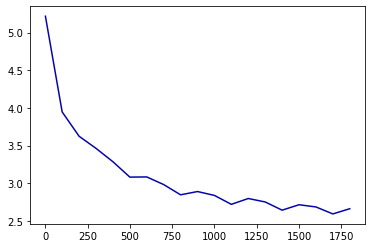

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 13
Iteration: 1900
Loss: 2.654833
Time: 2232.168623

### Starts Here ###

mpe. cviyo kalatiyi ya kumulonda wa munu uwa mubahima ndiku kuwa wavilinga no ule wolonga, "wwa mwenga na nalongila bani waye yasa mukuni wana yano iya mulanga. "hila mwiha na kwala ma muhala na wandu

### Ends Here ###
######################################


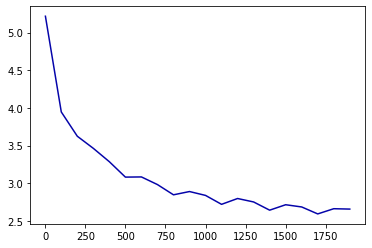

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 14
Iteration: 2000
Loss: 2.559896
Time: 2342.184857

### Starts Here ###

vu, kala chimutani longe. kalimula agoho weu uwa mulungu kwa muna hunyo makamulonga nhu utondo wa munhu yokya na kulu za mulingu, "ano yawenge mboli wa mukula mulunga mula kuzogwa na wakuya wayawikwa m

### Ends Here ###
######################################


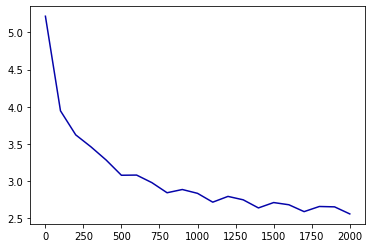

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 14
Iteration: 2100
Loss: 2.626810
Time: 2467.051891

### Starts Here ###

to ya mulonge. kaa, kawalongo bali chiko chonhe nhu husilo mulude kalomwa wa munigili. keivina kaika kawa wangu kulila na kumuhila za mweni ino na amulonge chinhumvi muni milo no watanza watemulowe ni

### Ends Here ###
######################################


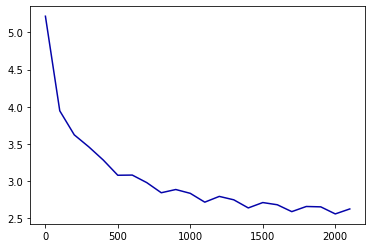

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 15
Iteration: 2200
Loss: 2.624971
Time: 2588.311372

### Starts Here ###

te ku vigala chili no kawangule wa sila itinge wa wanhu weya, nalima ni'himye vwe ukalu yasa wawenga mbali ma witula na cminiga, janyo weyekuligaha wanza wo wanhu wozona kauvindi waka maaba kuwauhule c

### Ends Here ###
######################################


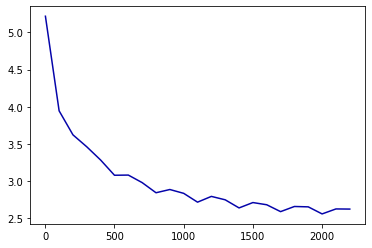

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 16
Iteration: 2300
Loss: 2.515815
Time: 2704.872559

### Starts Here ###

se, mbaya wa nhimwengolo mang'hinye ya mulango. mwayaha yomuheya kwa habaha ina hasaha kawakukela kayage sa ichilesi kuna wausengo wana mu uwalonga mbali muna dika mwela na watinde wakakule zasa ya kul

### Ends Here ###
######################################


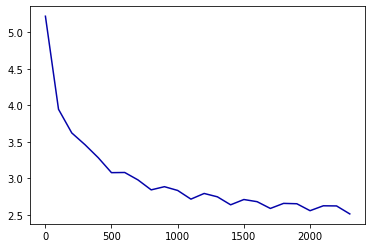

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 16
Iteration: 2400
Loss: 2.589504
Time: 2824.813201

### Starts Here ###

se yasonyo. "nhulila kulandung'hale na ivunha yamumunhi wa mbali chilisinza muni uwo mulugi wa mbuli hakulwulu una yaso yamuno wawa ni waili ya mu uniya yalogele. kwaviya kula samwawa voyalumgo, na chi

### Ends Here ###
######################################


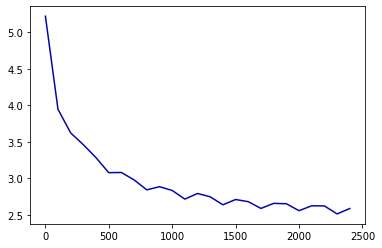

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 17
Iteration: 2500
Loss: 2.592261
Time: 2936.621189

### Starts Here ###

dili na kulanga kawa ngila na kuluuga. kawa chiwilo na wa muna iso yo kaweiha wasengala dawila. chivimagelile katandiga basa na kuto yalungu kamuna kawalongala nguli wake, na kakala na wanhu wiza weye

### Ends Here ###
######################################


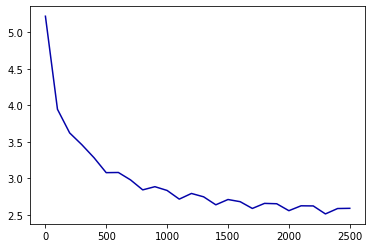

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 18
Iteration: 2600
Loss: 2.481605
Time: 3056.465230

### Starts Here ###

hu, mbali yosondiza mutigiliza yasuluka wa kulinge. kelu hakaminya ng'hali ihi diza chilenha chiligilo mana mwana wamu mwaye uwanye wa watago, lange wana wa wena ni kunhu wawalongali mena muna isi yasi

### Ends Here ###
######################################


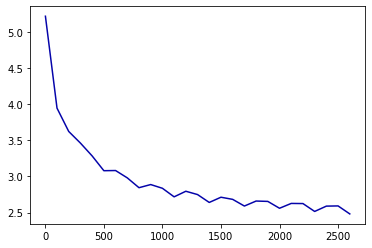

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 18
Iteration: 2700
Loss: 2.558160
Time: 3173.885235

### Starts Here ###

 hati?a igile ya mulengu ya kumuna itimundi niya ludili, na munhu yoyo wa kundisalo. yana mwengahi woke wa handi manhu wesi kewalengela, na kuwa chilongula kuwa chinhu, chichilinge. pesi ya mulungu waz

### Ends Here ###
######################################


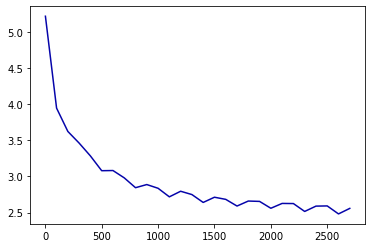

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 19
Iteration: 2800
Loss: 2.575779
Time: 3296.844713

### Starts Here ###

ffndi. mhomelize muna yamu uviya yeyulilile na mulodimwaka na wanhu wangugwe ni hadimwe na kumulungu na mwongila chiya mulangu wa mulonda huwa chelusito yasaha mungu wa mulungu mulangula kulung'ha chil

### Ends Here ###
######################################


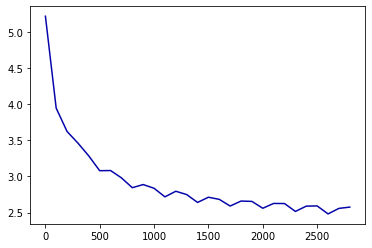

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 20
Iteration: 2900
Loss: 2.472289
Time: 3412.031831

### Starts Here ###

-do chilongo. mwa muni mulungusika wangula mhati igondi mabii mwing'ha manya kulengu wo waka diye muna ilili wa nhulili wa kuwa kuwana mwenya wangu na unhu na mulingu wa muwangu mbuchino cha chinhe yo

### Ends Here ###
######################################


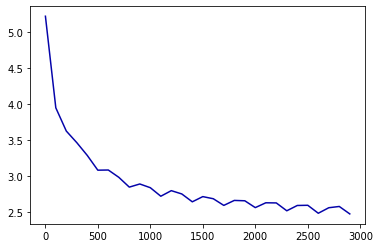

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 20
Iteration: 3000
Loss: 2.543051
Time: 3527.139828

### Starts Here ###

?ke. uvona kutamasa kamwang'hani yesu keilanga wetewa wamuna ibile kuwa nichimusungu waiho, chichila munhu mulongi kechino china chiyo chimwena uza umunhu uwangiza muno wa tusi ngula mulonga wawa kumum

### Ends Here ###
######################################


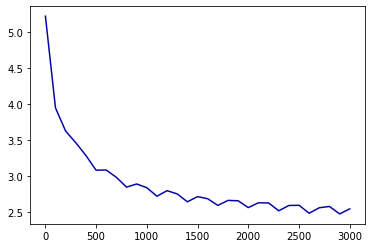

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 21
Iteration: 3100
Loss: 2.553631
Time: 3661.352003

### Starts Here ###

e chisa chihhulelila mbuli dusa kamanida kela hayalo kamahangu na wafhi ye wambuna mwana waya nda sawoviya disi mutala wanhu wa yahawa, chichinhu wa mulungu katandiza ku wodiya kulogela hunhu hawila we

### Ends Here ###
######################################


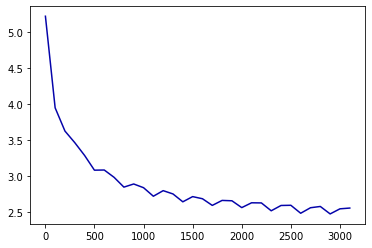

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 22
Iteration: 3200
Loss: 2.441466
Time: 3784.496780

### Starts Here ###

. vona yahula koza na kulandu kamulanga na yesu kawaha waja nya munhu yoko, hilunda niyo na howamwanguse ya kuledolila kuulinga, umala iwoku. walange vana mulosi, ino yawanhungo kwa kuwa ni sale zanhu

### Ends Here ###
######################################


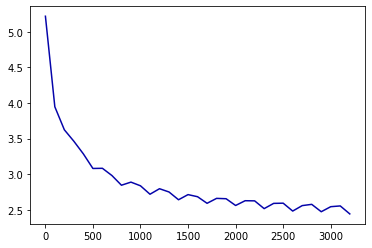

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 22
Iteration: 3300
Loss: 2.529057
Time: 3901.813756

### Starts Here ###

!, chimpute ye kuliliya mulungu, mmala katamzing'hana munguli ye uno wahamwangelo wawa niyatana zano iniya kizogela muluma ya habwili nhu chivimanye wowele na nguluna ika kuwa wangu na yawasa, na wakal

### Ends Here ###
######################################


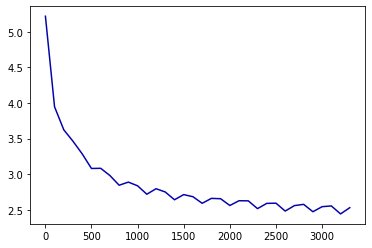

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 23
Iteration: 3400
Loss: 2.533861
Time: 4021.218806

### Starts Here ###

o chini chiku chilachinya mupana chilika na malilili mana idiga, "ne udondila kamusa kamwenga ini wana yahawanya mwa mulungu. wenpu wanimwa mabeme ya yasonya muna uiza kudawa umuling'ha we nhuwa wone w

### Ends Here ###
######################################


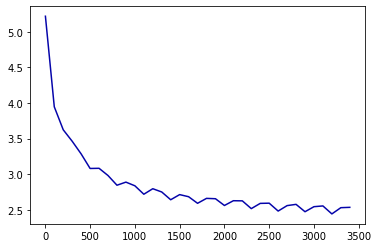

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 24
Iteration: 3500
Loss: 2.439931
Time: 4136.665440

### Starts Here ###

. vituma chakama ndiga kawa hona wengu kamanga kaadandike mwandika. wawa kuwa yana uviya ma mwaye, kanagang'hana kwa una bahi. mbali mulumge yewele muloso kova mbalu na yailiza kuse kakala na una kuwa

### Ends Here ###
######################################


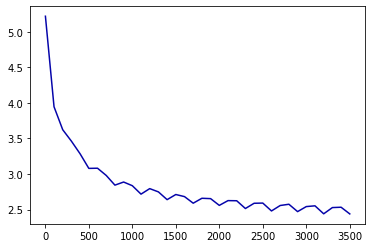

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 24
Iteration: 3600
Loss: 2.495695
Time: 4252.481611

### Starts Here ###

ye fandizo kwa iuhonga kamaila kudata kukumzang'a na mungu kamulenge wa chiya mva yahona mbani chilinga kayahalisa mulusi. kelo na kamtimwa yawomemwe mana sanyesi yesu kwa muni ika, sandi wake vawahena

### Ends Here ###
######################################


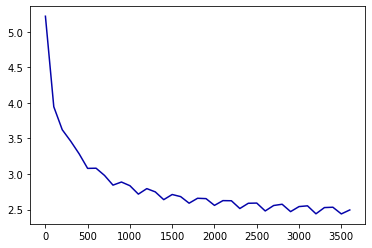

<Figure size 432x288 with 0 Axes>


######################################
Total iteration: 25
Iteration: 3700
Loss: 2.516661
Time: 4365.219012

### Starts Here ###

ito dese loje yakalila na mulungu na mudangu kabala kuzawaluwa wamahawe kwanaya dina yalangizi wavila kulandi wana wilangu, kagaha umwina iza muna iviya kulang'hinha mukaga viya mana um'hung'. noyela k

### Ends Here ###
######################################


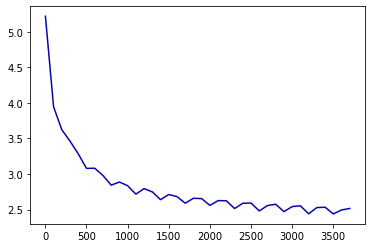

<Figure size 432x288 with 0 Axes>

In [3]:
import numpy as np
# from utils import char_to_ix, ix_to_char, one_hot, Graph
# from model import RNN
import pickle
import timeit

final_losss = []
totalcount = 0

def model(data='input.txt', hidden_size=256, seq_length=200, depth_size=2, batch_size=20, drop_rate=0.1,
          num_iteration=100, learning_rate=0.01, img_name='Figure'):
    # Open a training text file
    data = open(data, 'rb').read().decode('UTF-8')
    chars = list(set(data))
    chars.sort()
    data_size, vocab_size = len(data), len(chars)
    print('Data has %d total characters, %d unique characters.' % (data_size, vocab_size))

    # Make a dictionary that maps {character:index} and {index:character}
    ch2ix, ix2ch = char_to_ix(chars), ix_to_char(chars)

    # Set RNN model
    model = RNN(vocab_size, vocab_size, hidden_size, seq_length, depth_size, batch_size, drop_rate)

    cnt = 0
    losses = {}
    graph = Graph('Iteration', 'Loss')

    # Optimize model
    start = timeit.default_timer()
    for n in range(num_iteration):
        model.initialize_hidden_state()
        model.initialize_optimizer()

        # Split text by mini-batch with batch_size
        batch_length = data_size // batch_size
        for i in range(0, batch_length - seq_length, seq_length):
            mini_batch_X, mini_batch_Y = [], []

            for j in range(0, data_size - batch_length + 1, batch_length):
                mini_batch_X.append(one_hot(data[j + i:j + i + seq_length], ch2ix))
                mini_batch_Y.append([ch2ix[ch] for ch in data[j + i + 1:j + i + seq_length + 1]])

            mini_batch_X = np.array(mini_batch_X)
            mini_batch_Y = np.array(mini_batch_Y)

            model.optimize(mini_batch_X, mini_batch_Y, learning_rate=learning_rate)

            cnt += 1
            totalcount = cnt
            if cnt % 100 == 0 or cnt == 1:
                stop = timeit.default_timer()

                loss = model.loss()
                losses[cnt] = loss
                final_losss = losses

                print("\n######################################")
                print("Total iteration: %d" % (n + 1))
                print("Iteration: %d" % cnt)
                print("Loss: %f" % loss)
                print("Time: %f" % (stop - start))

                ix = np.random.randint(0, vocab_size)
                sample_ixes = model.sample(ix, 200)
                txt = ''.join(ix2ch[ix] for ix in sample_ixes)
                print("\n### Starts Here ###\n\n" + txt.rstrip() + "\n\n### Ends Here ###")
                print("######################################")

                graph_x = np.array(sorted(losses))
                graph_y = np.array([losses[key] for key in graph_x])
                graph.update(graph_x, graph_y, img_name=img_name)

    return model, ch2ix, ix2ch


if __name__ == "__main__":
    ##########
    data = 'cwe-train'
    num_iteration = 25
    optimizer = 'adagrad'
    ##########

    infile = data + '.txt'
    outfile = data + '_' + str(num_iteration) + '_' + optimizer

    result, ch2ix, ix2ch = model(data=infile, num_iteration=num_iteration, img_name=outfile)

    file = open('./result/' + outfile + '.pickle', 'wb')
    pickle.dump(result, file)
    pickle.dump(ch2ix, file)
    pickle.dump(ix2ch, file)
    file.close()

In [15]:
import numpy as np
# from utils import char_to_ix, ix_to_char, one_hot, Graph
# from model import RNN
import pickle
import timeit


def model(data='input.txt', hidden_size=256, seq_length=200, depth_size=1, batch_size=64, drop_rate=0.1,
          num_iteration=100, learning_rate=0.01, img_name='Figure'):
    # Open a training text file
    data = open(data, 'rb').read().decode('UTF-8')
    chars = list(set(data))
    chars.sort()
    data_size, vocab_size = len(data), len(chars)
    print('Data has %d total characters, %d unique characters.' % (data_size, vocab_size))

    # Make a dictionary that maps {character:index} and {index:character}
    ch2ix, ix2ch = char_to_ix(chars), ix_to_char(chars)

    # Set RNN model
    model = RNN(vocab_size, vocab_size, hidden_size, seq_length, depth_size, batch_size, drop_rate)

    cnt = 0
    losses = {}
    graph = Graph('Iteration', 'Loss')

    # Optimize model
    start = timeit.default_timer()
    for n in range(num_iteration):
        model.initialize_hidden_state()
        model.initialize_optimizer()

        # Split text by mini-batch with batch_size
        batch_length = data_size // batch_size
        for i in range(0, batch_length - seq_length, seq_length):
            mini_batch_X, mini_batch_Y = [], []

            for j in range(0, data_size - batch_length + 1, batch_length):
                mini_batch_X.append(one_hot(data[j + i:j + i + seq_length], ch2ix))
                mini_batch_Y.append([ch2ix[ch] for ch in data[j + i + 1:j + i + seq_length + 1]])

            mini_batch_X = np.array(mini_batch_X)
            mini_batch_Y = np.array(mini_batch_Y)

            model.optimize(mini_batch_X, mini_batch_Y, learning_rate=learning_rate)

            cnt += 1
            if cnt % 100 == 0 or cnt == 1:
                stop = timeit.default_timer()

                loss = model.loss()
                losses[cnt] = loss

                print("\n######################################")
                print("Total iteration: %d" % (n + 1))
                print("Iteration: %d" % cnt)
                print("Loss: %f" % loss)
                print("Time: %f" % (stop - start))

                ix = np.random.randint(0, vocab_size)
                sample_ixes = model.sample(ix, 200)
                txt = ''.join(ix2ch[ix] for ix in sample_ixes)
                print("\n### Starts Here ###\n\n" + txt.rstrip() + "\n\n### Ends Here ###")
                print("######################################")

                graph_x = np.array(sorted(losses))
                graph_y = np.array([losses[key] for key in graph_x])
                graph.update(graph_x, graph_y, img_name=img_name)

    return model, ch2ix, ix2ch


if __name__ == "__main__":
    ##########
    data = 'sw-train'
    num_iteration = 1
    optimizer = 'adagrad'
    ##########

    infile = data + '.txt'
    outfile = data + '_' + str(num_iteration) + '_' + optimizer

    result, ch2ix, ix2ch = model(data=infile, num_iteration=num_iteration, img_name=outfile)

    file = open('./result/' + outfile + '.pickle', 'wb')
    pickle.dump(result, file)
    pickle.dump(ch2ix, file)
    pickle.dump(ix2ch, file)
    file.close()

0